# ML-Fundamentals - Lineare Regression - Exercise: Multivariate Linear Regression

In [3]:
def levenshtein_distance(a, b):
    """Return the Levenshtein edit distance between two strings *a* and *b*."""
    if a == b:
        return 0
    if len(a) < len(b):
        a, b = b, a
    if not a:
        return len(b)
    previous_row = range(len(b) + 1)
    for i, column1 in enumerate(a):
        current_row = [i + 1]
        for j, column2 in enumerate(b):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (column1 != column2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]  
    
    
print(levenshtein_distance("boo hoo", "hoo hoo"))

1


## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge) 
  * [Modules](#Python-Modules)
* [Exercises - Multivariate Linear Regression](#Exercises---Multivariate-Linear-Regression)
  * [Create Features](#Create-Features)
  * [Linear Hypothesis](#Linear-Hypothesis)
  * [Generate Target Values](#Generate-Target-Values)
  * [Plot The Data](#Plot-The-Data)
  * [Cost Function](#Cost-Function)
  * [Gradient Descent](#Gradient-Descent)
  * [Training and Evaluation](#Training-and-Evaluation)
  * [Feature Scaling](#Feature-Scaling)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature) 
* [Licenses](#Licenses)

## Introduction

In this exercise you will implement the _multiivariate linear regression_, a model with two or more predictors and one response variable (opposed to one predictor using univariate linear regression). The whole exercise consists of the following steps:

1. Generate values for two predictors (X)
2. Implement a linear function as hypothesis (model) 
3. Generate values for the response (Y / target values)
4. Plot the X1-X2-Y values in a 3D plot.
5. Write a function to quantify your model (cost function)
6. Implement the gradient descent algorithm to train your model (optimizer) 
7. Visualize your training process and results
8. Apply feature scaling (pen & paper)

## Requirements
### Knowledge

You should have a basic knowledge of:
- Univariate lineare regression
- Multivariate linear regression
- Squared error
- Gradient descent
- numpy
- matplotlib

Suitable sources for acquiring this knowledge are:
- [Multivariate Linear Regression Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/multivariate_linear_regression.php) by Christian Herta and his [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/multivariateLinearRegression.pdf) (German)
- Chapter 2 of the open classroom [Machine Learning](http://openclassroom.stanford.edu/MainFolder/CoursePage.php?course=MachineLearning) by Andrew Ng
- Chapter 5.1 of [Deep Learning](http://www.deeplearningbook.org/contents/ml.html) by Ian Goodfellow 
- Some parts of chapter 1 and 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop
- [numpy quickstart](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [Matplotlib tutorials](https://matplotlib.org/tutorials/index.html)

### Python Modules

By [deep.TEACHING](https://www.deep-teaching.org/) convention, all python modules needed to run the notebook are loaded centrally at the beginning. 


## Exercise - Multivariate Linear Regression

We will only use two features in this notebook, so we are still able to plot them together with the target in a 3D plot. But your implementation should also be capable of handling more (except the plots). 

In [14]:
# External Modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

%matplotlib notebook

### Create Features

First we will create some features. The features should be in a 2D numpy array, the rows seperating the different feature vectors, the columns containing the features. Each feature should be uniformly distributed in a specifiable range.

**Task:**

Implement the function to generate a feature matrix (numpy array).

In [15]:
import numpy as np
def create_feature_matrix(sample_size, n_features, x_min, x_max):
    '''creates random feature vectors based on a lienar function in a given interval
    
    Args:
        sample_size: number feature vectors
        n_features: number of features for each vector
        x_min: lower bound value ranges
        x_max: upper bound value ranges
    
    Returns:
        x: 2D array containing feature vecotrs with shape (sample_size, n_features)
    '''
    features = np.append(np.ones((sample_size,1)),np.random.uniform(x_min, x_max, (sample_size, n_features)),axis=1)  
    
    return features   
    

In [16]:
sample_size = 100
n_features = 2
x_min = [1.5,-0.5]
x_max = [11.,5.0]

X = create_feature_matrix(sample_size, n_features, x_min, x_max)

In [17]:
assert len(X[:,0]) == sample_size
assert len(X[0,:]) == n_features+1
for i in range(n_features):
    assert np.max(X[:,i+1]) <= x_max[i]
    assert np.min(X[:,i+1]) >= x_min[i]

### Linear Hypothesis
A short recap, a hypothesis $h_\theta(x)$ is a certain function that we believe is similar to a target function that we like to model. A hypothesis $h_\theta(x)$ is a function of $x$ with fixed parameters $\theta$. 

Here we have $n$ features $x = [x_1, \ldots, x_n ]$ and $n+1$ $\theta$s:

$$
h_\theta(x) = \theta_{0} + \theta_{1} x_1 + \ldots \theta_n x_n 
$$

adding an extra element to $\bf x$ for convenience, this could also be rewritten as:

$$
h_\theta(x) = \theta_{0} x_0 + \theta_{1} x_1 + \ldots \theta_n x_n 
$$

with $x_0 = 1$ for all feature vectors.

**Task:**

Implement hypothesis $h_\theta(x)$ in the method `linear_hypothesis` and return it as a function. 

In [18]:
def linear_hypothesis(thetas):
    ''' Combines given list argument in a linear equation and returns it as a function
    
    Args:
        thetas: list of coefficients
        
    Returns:
        lambda that models a linear function based on thetas and x
    '''
    def linear(x):
        return np.dot(x, thetas)
    return linear

In [19]:
assert len(linear_hypothesis([.1,.2,.3])(X)) == sample_size

### Generate Target Values

**Task:**

Use your implemented `linear_hypothesis` inside the next function to generate some target values $Y$. Additionally add some Gaussian noise.

In [20]:
def generate_targets(X, theta, sigma):
    ''' Combines given arguments in a linear equation with X, 
    adds some Gaussian noise and returns the result
    
    Args:
        X: 2D numpy feature matrix
        theta: list of coefficients
        sigma: standard deviation of the gaussian noise
        
    Returns:
        target values for X
    '''
    
    hypo = linear_hypothesis(theta)
    y_calc = hypo(X)
    y_gaussian = np.random.normal(y_calc, sigma)
    
    return y_gaussian

In [21]:
theta = (2., 3., -4.)
sigma = 3.
y = generate_targets(X, theta, sigma)

In [22]:
assert len(y) == sample_size

### Plot The Data

**Task:**

Plot the data $D = \{(x^{(1)}_1,x^{(1)}_2,y^{(1)}), \ldots, (x^{(n)}_1,x^{(n)}_2,y^{(n)})\}$ in a 3D scatter plot. The plot should look like the following:

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/exercise-multivariate-linear-regression-scatter.png" width="512" alt="internet connection needed">

**Sidenote:**

The command `%matplotlib notebook` (instead of `%matplotlib inline`) creates an interactive (e.g. rotatable) plot.

In [23]:
%matplotlib inline

def plot_data_scatter(features, targets):
    """ Plots the features and the targets in a 3D scatter plot
    
    Args:
        features: 2D numpy-array features
        targets: ltargets
    """
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
   
    ax.scatter(xs=features[:, 0], ys=features[:, 1], zs=targets)
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_zlabel('Y')

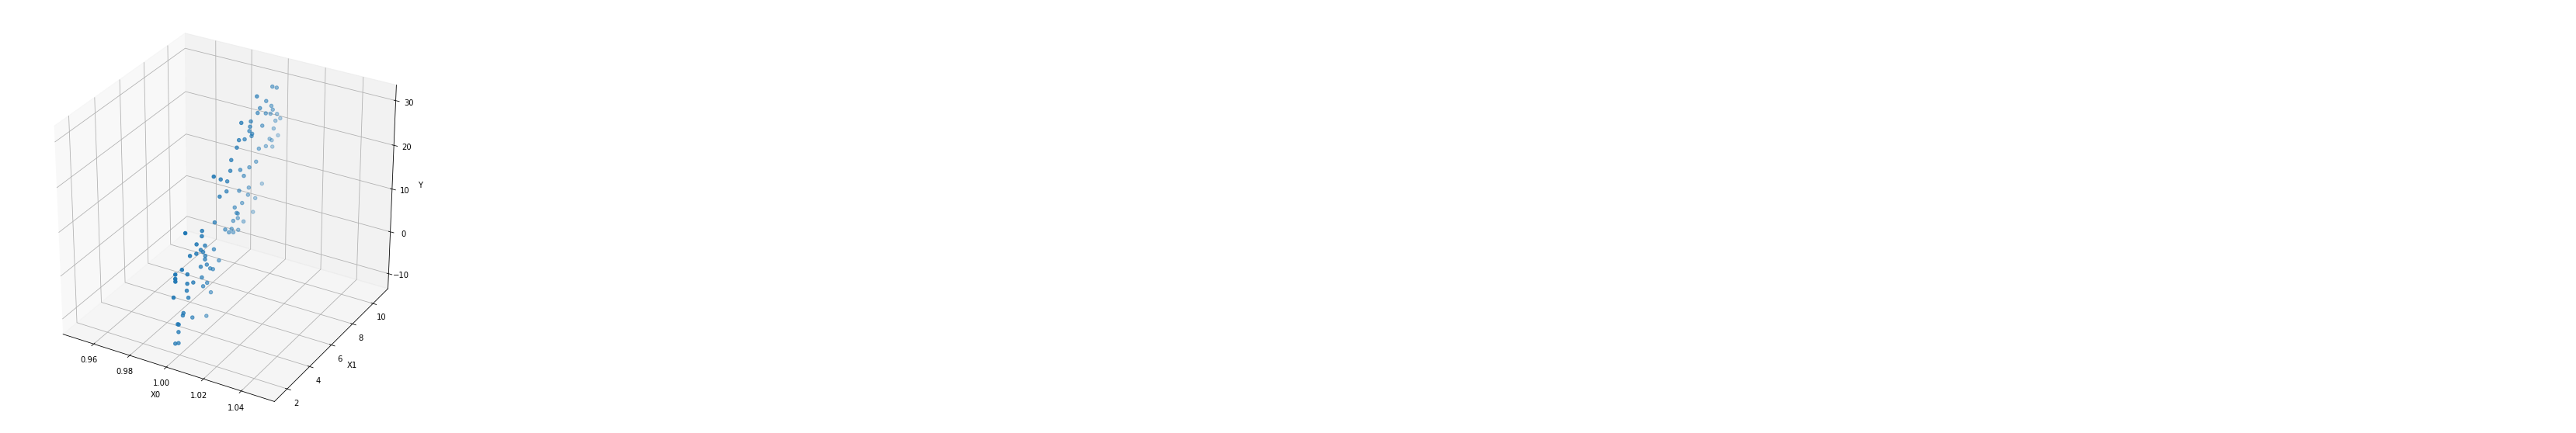

In [24]:
plot_data_scatter(X, y)

### Cost Function
A cost function $J$ depends on the given training data $D$ and hypothesis $h_\theta(x)$. In the context of the linear regression, the cost function measures how wrong a model is regarding its ability to estimate the relationship between $x$ and $y$ for specific $\theta$ values. Later we will treat this as an optimization problem and try to minimize the cost function $J_D(\theta)$ to find optimal $\theta$ values for our hypothesis $h_\theta(x)$. The cost function we use in this exercise is the [Mean-Squared-Error](https://en.wikipedia.org/wiki/Mean_squared_error) cost function:

\begin{equation}
    J_D(\theta)=\frac{1}{2m}\sum_{i=1}^{m}{(h_\theta(x_i)-y_i)^2}
\end{equation}

Implement the cost function $J_D(\theta)$ in the method `mse_cost_function`. The method should return a function that takes the values of $\theta_0$ and $\theta_1$ as an argument.

Sidenote, the terms loss function or error function are often used interchangeably in the field of Machine Learning.

In [58]:
def mse_cost_function(x, y):
    ''' Implements MSE cost function as a function J(theta) on given traning data 
    
    Args:
        x: vector of x values 
        y: vector of ground truth values y 
        
    Returns:
        lambda J(theta_0, theta_1) that models the cost function
    '''
    def cost_funktion(theta):
        curr_hypothesis = linear_hypothesis(theta)
        
        return 1/(2*len(theta)) * np.sum((curr_hypothesis(x) - y)**2, axis=0)
    return cost_funktion

In [59]:
J = mse_cost_function(X, y)
print(J(theta))

1.6568185588532898e+16


###  Gradient Descent

A short recap, the gradient descent algorithm is a first-order iterative optimization for finding a minimum of a function. From the current position in a (cost) function, the algorithm steps proportional to the negative of the gradient and repeats this until it reaches a local or global minimum and determines. Stepping proportional means that it does not go entirely in the direction of the negative gradient, but scaled by a fixed value $\alpha$ also called the learning rate. Implementing the following formalized update rule is the core of the optimization process:

\begin{equation}
    \theta_{j_{new}} \leftarrow \theta_{j_{old}} - \alpha * \frac{\delta}{\delta\theta_{j_{old}}} J(\theta_{old})
\end{equation}

**Task:**

Implement the function to update all theta values.

In [56]:
def update_theta(x, y, theta, learning_rate):
    ''' Updates learnable parameters theta 
    
    The update is done by calculating the partial derivities of 
    the cost function including the linear hypothesis. The 
    gradients scaled by a scalar are subtracted from the given 
    theta values.
    
    Args:
        x: 2D numpy array of x values
        y: array of y values corresponding to x
        theta: current theta values
        learning_rate: value to scale the negative gradient 
        
    Returns:
        t0: Updated theta_0
        t1: Updated theta_1
    '''
    hypothesis = linear_hypothesis(theta)
    
    return theta - learning_rate * 1/len(theta) * x.T.dot(hypothesis(x)-y)
    

In [57]:
theta = update_theta(X, y, [42., 42., 42.], 42.42)

Using the `update_theta` method, you can now implement the gradient descent algorithm. Iterate over the update rule to find the values for $\theta$ that minimize our cost function $J_D(\theta)$. This process is often called training of a machine learning model. 

**Task:**
- Implement the function for the gradient descent.
- Create a history of all theta and cost values and return them.

In [16]:
def gradient_descent(learning_rate, theta, iterations, x, y):
    ''' Minimize theta values of a linear model based on MSE cost function
    
    Args:
        learning_rate: scalar, scales the negative gradient 
        theta: initial theta values
        x: vector, x values from the data set
        y: vector, y values from the data set
        iterations: scalar, number of theta updates
        
    Returns:
        history_cost: cost after each iteration
        history_theta: Updated theta values after each iteration
    '''
    history_cost = []
    history_theta= []
    c = mse_cost_function(x, y)
    for i in range(iterations):
        theta = update_theta(x, y, theta, learning_rate)
        history_cost.append(c(theta))
        history_theta.append(theta)
        
    return history_cost, history_theta


### Training and Evaluation

**Task:**

Choose an appropriate learning rate, number of iterations and initial theta values and start the training

In [17]:
# Your implementation:

alpha = 0.001 # assign an appropriate value
nb_iterations = 100 # assign an appropriate value
start_values_theta = [1., 2., 4.] # assign appropriate values
history_cost, history_theta = gradient_descent(alpha, start_values_theta, nb_iterations, X, y)

Now that the training has finished we can visualize our results.

**Task:**

Plot the costs over the iterations. If you have used `fig = plt.figure()` and `ax = fig.add_subplot(111)` in the last plot, use it again here, else the plot will be added to the last plot instead of a new one.

Your plot should look similar to this one:

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/exercise-multivariate-linear-regression-costs.png" width="512" alt="internet connection needed">

In [18]:
def plot_progress(costs):
    """ Plots the costs over the iterations
    
    Args:
        costs: history of costs
    """
    plt.plot(range(0, len(costs)), costs)
    plt.show()

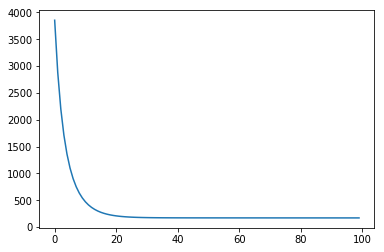

costs before the training:	  3852.345972305042
costs after the training:	  171.51742687370552


In [19]:
plot_progress(history_cost)
print("costs before the training:\t ", history_cost[0])
print("costs after the training:\t ", history_cost[-1])

**Task:**

Finally plot the decision hyperplane (just a plain plane here though) together with the data in a 3D plot.

Your plot should look similar to this one:

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/exercise-multivariate-linear-regression-scatter_and_boundary.png" width="512" alt="internet connection needed">

In [52]:
def evaluation_plt(x, y, final_theta):
    ''' Plots a cost curve and the decision boundary
    
    The Method plots a cost curve from a given training process (cost_hist). 
    It also plots the data set (x,y) and draws a linear decision boundary 
    with the parameters theta_0 and theta_1 into the plotted data set.
    
    Args:
        cost_hist: vector, history of all cost values from a opitmization
        theta_0: scalar, model parameter for boundary
        theta_1: scalar, model parameter for boundary
        x: vector, x values from the data set
        y: vector, y values from the data set
    '''
    
    from mpl_toolkits.mplot3d import Axes3D
    
    # initialize the figure
    fig = plt.figure()

    ax = Axes3D(fig)
    
    ax.scatter(x.T[1], x.T[2], y)
    
    # create the surface.
    surf = ax.plot_trisurf(x.T[1], x.T[2], linear_hypothesis(final_theta)(x), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
   

thetas before the training:	 [ 0.58446027 -0.43004466  2.33123784]
thetas after the training:	 [ 0.66148593  3.09141849 -3.61986648]


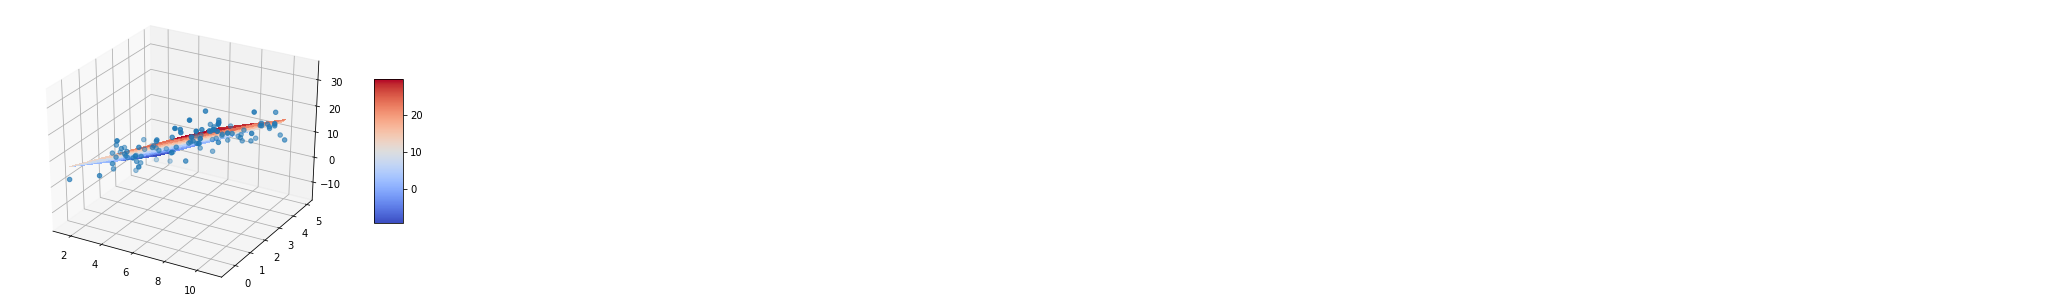

In [53]:
evaluation_plt(X, y, history_theta[-1])
print("thetas before the training:\t", history_theta[0])
print("thetas after the training:\t", history_theta[-1])

### Feature Scaling

Now suppose the following features $\bf x$:

In [22]:
X1 = np.array([[0.0001, 2000],
              [0.0002, 1800],
              [0.0003, 1600]], dtype=np.float32)


*Optional:*

You can even execute the cell above and start running your notebook again from top (all **except** executing the cell to generate your features, which would overwrite these new features).

When you start training you should notice that your costs do not decrease, maybe even increase, if you have not adjusted your learning rate (training might also throw an overflow warning).

**Task:**

This task can be done via **pen & paper** or by inserting some code below. Either way, you should be able to solve both tasks below on paper only using a calculator.

1. Apply feature scaling onto `X` using the *mean* and the *standard deviation*. What values do the scaled features have?

2. After the training with scaled features your new $\theta'$ values will be very high, something like: $\theta'=[-7197,  326, -326]$ (you can try it but you do not have to). Suppose $\theta'=[-7197,  326, -326]$. What are the corresponding $\theta$ values for the unscaled data?

3. Answer the question: What would happen if we did not apply feature scaling and we would use polynomial regression for `X`?

## Summary and Outlook

During this exercise, the linear regression was extended to multidimensional feature space and feature scaling was practiced. You should be able to answer the following questions:
- How does the implementation of the multivariate regression differ from the univariate one?
- Why do we apply feature scaling?
- Why does feature scaling help?

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Multivariate Linear Regression <br/>
by Christian Herta, Klaus Strohmenger, Benjamin Voigt <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Klaus Strohmenger, Benjamin Voigt

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.